In [2]:
chemin = r'C:\Users\HP\Desktop\ISEP2\Semestre2\Machine Learning\Projet\Models\train_test_split.dill'
with open(chemin, 'rb') as f:
    x_train, x_test, y_train, y_test = dill.load(f)

In [14]:
import logging
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

### Chargement des modèles sauvegardés

In [1]:
from pathlib import Path
import dill

# Répertoires des modèles
MODEL_DIR = r'C:\Users\HP\Desktop\ISEP2\Semestre2\Machine Learning\Projet\Models'

# Chemins vers les modèles
model_paths = {
    "nb": Path(MODEL_DIR, "nb_best_model_optimized.dill"),
    "rl": Path(MODEL_DIR, "rl_best_model_optimized.dill"),
    "rf": Path(MODEL_DIR, "rf_best_model_optimized.dill"),
    "xgb": Path(MODEL_DIR, "xgb_best_model_optimized.dill")
}

# Chargement des modèles
models = {}
for name, path in model_paths.items():
    with open(path, "rb") as f:
        models[name] = dill.load(f)
        print(f"{name.upper()} chargé avec succès.")


NB chargé avec succès.
RL chargé avec succès.
RF chargé avec succès.
XGB chargé avec succès.


### Vérification du chargement

In [3]:
from sklearn.metrics import roc_auc_score, classification_report

for name, model in models.items():
    print(f"\n--- {name.upper()} ---")
    print(f"Seuil optimal : {model.threshold}")
    
    # Prédictions sur le jeu de test
    proba = model.predict_proba(x_test)[:, 1]
    preds = model.predict(x_test)
    
    # Évaluation
    print(f"AUC : {roc_auc_score(y_test, proba):.4f}")
    print(f"Classification Report :\n{classification_report(y_test, preds)}")



--- NB ---
Seuil optimal : 0.34
AUC : 0.8803
Classification Report :
              precision    recall  f1-score   support

           0       0.92      0.91      0.91      1851
           1       0.62      0.65      0.63       423

    accuracy                           0.86      2274
   macro avg       0.77      0.78      0.77      2274
weighted avg       0.86      0.86      0.86      2274


--- RL ---
Seuil optimal : 0.37
AUC : 0.8950
Classification Report :
              precision    recall  f1-score   support

           0       0.92      0.93      0.92      1851
           1       0.67      0.63      0.65       423

    accuracy                           0.87      2274
   macro avg       0.79      0.78      0.79      2274
weighted avg       0.87      0.87      0.87      2274


--- RF ---
Seuil optimal : 0.52
AUC : 0.8877
Classification Report :
              precision    recall  f1-score   support

           0       0.87      0.98      0.92      1851
           1       0.82    

### Construction du modèle de Stacking avec SVM comme méta-modèle

#### Étape 1 : Récupération des prédictions de chaque modèle sur le jeu d'entraînement

In [5]:
from sklearn.model_selection import StratifiedKFold
from sklearn.svm import SVC
from sklearn.metrics import roc_auc_score, classification_report
import numpy as np

# Initialisation du méta-modèle (SVM avec kernel linéaire)
meta_model = SVC(probability=True, kernel='linear', random_state=42)

# Préparation des prédictions pour le modèle de stacking
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Matrices pour stocker les prédictions
train_meta_features = np.zeros((x_train.shape[0], len(models)))
test_meta_features = np.zeros((x_test.shape[0], len(models)))

# Pour chaque modèle de base, on effectue une prédiction sans réentraînement
for idx, (name, model) in enumerate(models.items()):
    print(f"Préparation des features pour le modèle : {name.upper()}")

    # Prédictions pour chaque split
    for train_idx, val_idx in cv.split(x_train, y_train):
        x_val = x_train.iloc[val_idx]
        
        # Prédiction sur le split de validation (pas de fit, les modèles sont déjà optimisés)
        val_proba = model.model.predict_proba(x_val)[:, 1]
        train_meta_features[val_idx, idx] = val_proba
    
    # Prédiction sur le jeu de test (une seule fois, puisque le modèle est déjà optimisé)
    test_meta_features[:, idx] = model.model.predict_proba(x_test)[:, 1]

# Afficher un aperçu des features générées
print("Features d'entraînement pour le stacking :")
print(train_meta_features[:5])
print("Features de test pour le stacking :")
print(test_meta_features[:5])


Préparation des features pour le modèle : NB
Préparation des features pour le modèle : RL
Préparation des features pour le modèle : RF
Préparation des features pour le modèle : XGB
Features d'entraînement pour le stacking :
[[0.00960355 0.05735801 0.02       0.05737041]
 [0.25925542 0.2841352  0.13333333 0.09438966]
 [0.0108885  0.06988061 0.03333333 0.18372589]
 [0.01046361 0.06499499 0.02666667 0.12968144]
 [0.47616131 0.81240611 0.81333333 0.76327455]]
Features de test pour le stacking :
[[0.35646503 0.45206787 0.24666667 0.51034987]
 [0.02905297 0.14033531 0.46       0.77017957]
 [0.00254426 0.0098587  0.03333333 0.09651577]
 [0.04122299 0.0518571  0.07333333 0.06827725]
 [0.04344414 0.0889681  0.12       0.12680806]]


#### Étape 2 : Entraînement du méta-modèle SVM sur les features de base

In [6]:
print("\n=== Entraînement du méta-modèle SVM ===")
meta_model.fit(train_meta_features, y_train)

# Prédictions finales sur le jeu de test
stacked_proba = meta_model.predict_proba(test_meta_features)[:, 1]
stacked_pred = (stacked_proba >= 0.5).astype(int)

# Évaluation
print("\n=== Évaluation du modèle de Stacking ===")
print(f"AUC : {roc_auc_score(y_test, stacked_proba):.4f}")
print(f"Classification Report :\n{classification_report(y_test, stacked_pred)}")



=== Entraînement du méta-modèle SVM ===

=== Évaluation du modèle de Stacking ===
AUC : 0.9000
Classification Report :
              precision    recall  f1-score   support

           0       0.91      0.94      0.93      1851
           1       0.70      0.61      0.66       423

    accuracy                           0.88      2274
   macro avg       0.81      0.78      0.79      2274
weighted avg       0.88      0.88      0.88      2274



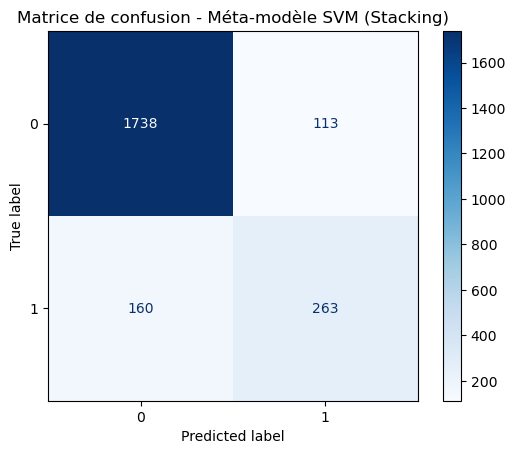

In [7]:
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Récupération des classes
class_names = meta_model.classes_

# Affichage de la matrice de confusion
ConfusionMatrixDisplay.from_estimator(
    meta_model, test_meta_features, y_test,
    display_labels=class_names,
    normalize=None,  # Tu peux mettre 'true' pour afficher les pourcentages
    cmap=plt.cm.Blues
)
plt.title("Matrice de confusion - Méta-modèle SVM (Stacking)")
plt.show()


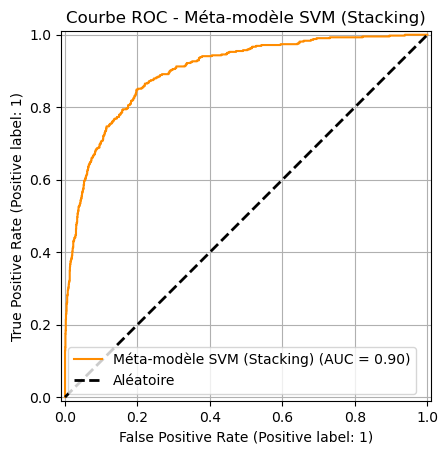

In [8]:
from sklearn.metrics import RocCurveDisplay
import matplotlib.pyplot as plt

# Affichage de la courbe ROC
RocCurveDisplay.from_estimator(
    meta_model, 
    test_meta_features, 
    y_test,
    name="Méta-modèle SVM (Stacking)",
    color='darkorange'
)

plt.plot([0, 1], [0, 1], 'k--', lw=2, label='Aléatoire')
plt.title("Courbe ROC - Méta-modèle SVM (Stacking)")
plt.legend()
plt.grid()
plt.show()


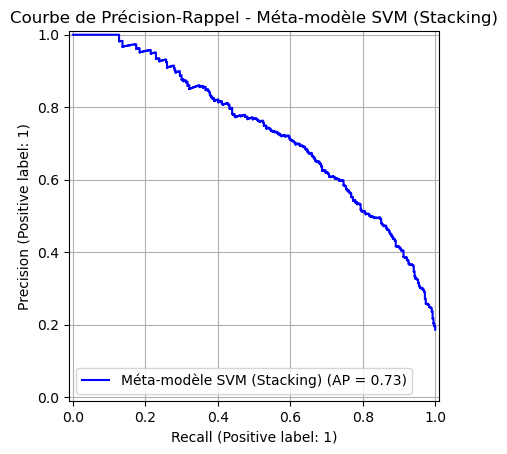

In [9]:
from sklearn.metrics import PrecisionRecallDisplay
import matplotlib.pyplot as plt

# Affichage de la courbe Précision-Rappel
PrecisionRecallDisplay.from_estimator(
    meta_model, 
    test_meta_features, 
    y_test,
    name="Méta-modèle SVM (Stacking)",
    color='blue'
)

plt.title("Courbe de Précision-Rappel - Méta-modèle SVM (Stacking)")
plt.grid()
plt.show()


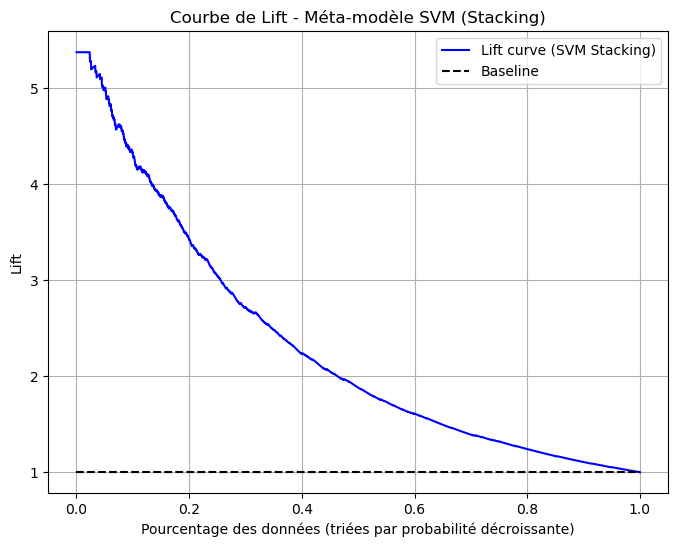

In [10]:
import numpy as np
import matplotlib.pyplot as plt

# 1. Prédire les probabilités avec le méta-modèle SVM
y_pred_proba = meta_model.predict_proba(test_meta_features)[:, 1]

# 2. Trier les résultats par score décroissant
sorted_indices = np.argsort(y_pred_proba)[::-1]
y_test_sorted = y_test.values[sorted_indices]
y_pred_sorted = y_pred_proba[sorted_indices]

# 3. Calculer le lift
n_samples = len(y_test)
cumulative_y_true = np.cumsum(y_test_sorted)
perc_samples = np.arange(1, n_samples + 1) / n_samples
lift = cumulative_y_true / (perc_samples * cumulative_y_true[-1])

# 4. Tracer la courbe de lift
plt.figure(figsize=(8, 6))
plt.plot(perc_samples, lift, label='Lift curve (SVM Stacking)', color='blue')
plt.plot([0, 1], [1, 1], 'k--', label='Baseline')
plt.xlabel('Pourcentage des données (triées par probabilité décroissante)')
plt.ylabel('Lift')
plt.title('Courbe de Lift - Méta-modèle SVM (Stacking)')
plt.legend()
plt.grid()
plt.show()


#### Sauvegarde du modèle

In [16]:
from pathlib import Path
import dill

# Définir le répertoire et le nom du fichier
MODEL_DIR = r'C:\Users\HP\Desktop\ISEP2\Semestre2\Machine Learning\Projet\Models'
meta_model_path_name = Path(MODEL_DIR, "stacking_meta_model_svm.dill")

# Sauvegarder uniquement le méta-modèle SVM
logger.info(f"Meta-model path name: {meta_model_path_name}")
with open(meta_model_path_name, "wb") as fp:
    dill.dump(meta_model, fp)  # Sauvegarde du méta-modèle SVM

logger.info(f"Stacking meta-model saved at: {meta_model_path_name}")


INFO:__main__:Meta-model path name: C:\Users\HP\Desktop\ISEP2\Semestre2\Machine Learning\Projet\Models\stacking_meta_model_svm.dill
INFO:__main__:Stacking meta-model saved at: C:\Users\HP\Desktop\ISEP2\Semestre2\Machine Learning\Projet\Models\stacking_meta_model_svm.dill
